# ML for Business Analytics - Final Project


## Business Understanding

The main business goal of the project is to develop a predictive model that can determine whether a given flight will be delayed or not, using the scheduled departure information. By accurately predicting flight delays, airlines can proactively manage their resources, optimize scheduling, and minimize disruptions. This predictive model can assist in making informed decisions regarding flight operations, crew allocation, and customer service, ultimately leading to improved on-time performance and customer satisfaction.

## Data Understanding

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
!pip install openml
import openml
import seaborn as sn



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 71.4 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=b870e9c70d91646b3965db9252dfc7a6e94dfa008e2e105c7e976c1d57c97c17
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff


In [9]:
# Loading the dataset
ml_data = openml.datasets.get_dataset(1169)
X, y, _, _ = ml_data.get_data(target=ml_data.default_target_attribute)
features = [f.name for i,f in ml_data.features.items()][:-1]
data = pd.DataFrame(X, columns=features)
data['Delay'] = y

data.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,269.0,SFO,IAH,3,15.0,205.0,1
1,US,1558.0,PHX,CLT,3,15.0,222.0,1
2,AA,2400.0,LAX,DFW,3,20.0,165.0,1
3,AA,2466.0,SFO,DFW,3,20.0,195.0,1
4,AS,108.0,ANC,SEA,3,30.0,202.0,0


In [10]:
# Data understanding
data.info()
print()
print("conclusions: \n 1- The dataset contains 539,383 rows.  \n 2- The non-null count for each column indicates that there are no missing values in the dataset. \n 3- The memory usage is approximately 16.0 MB, suggesting that the dataset is relatively large but can still be managed \n   efficiently in memory for most analytical tasks.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Airline      539383 non-null  category
 1   Flight       539383 non-null  float64 
 2   AirportFrom  539383 non-null  category
 3   AirportTo    539383 non-null  category
 4   DayOfWeek    539383 non-null  category
 5   Time         539383 non-null  float64 
 6   Length       539383 non-null  float64 
 7   Delay        539383 non-null  category
dtypes: category(5), float64(3)
memory usage: 16.0 MB

conclusions: 
 1- The dataset contains 539,383 rows.  
 2- The non-null count for each column indicates that there are no missing values in the dataset. 
 3- The memory usage is approximately 16.0 MB, suggesting that the dataset is relatively large but can still be managed 
   efficiently in memory for most analytical tasks.


Statistics for Airlines:
count     539383
unique        18
top           WN
freq       94097
Name: Airline, dtype: object

Statistics for Length:
count    539383.000000
mean        132.202007
std          70.117016
min           0.000000
25%          81.000000
50%         115.000000
75%         162.000000
max         655.000000
Name: Length, dtype: float64



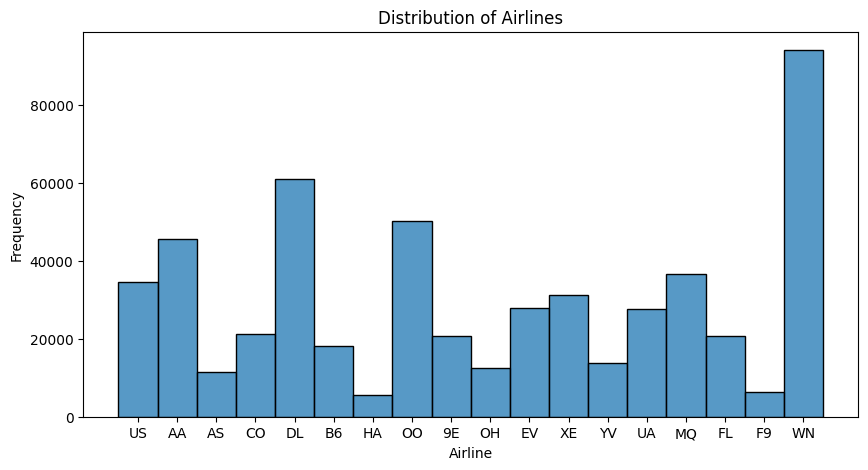

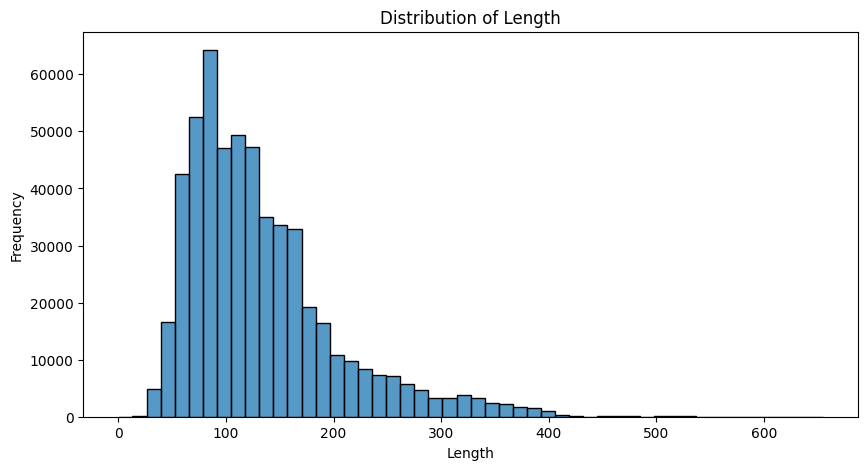

In [10]:
Airline = data.iloc[:, 0]
Length = data.iloc[:, 6]

print(f'Statistics for Airlines:\n{Airline.describe()}\n')
print(f'Statistics for Length:\n{Length.describe()}\n')

plt.figure(figsize=(10, 5))
sn.histplot(Airline, bins=50)
plt.title('Distribution of Airlines')
plt.xlabel('Airline')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sn.histplot(Length, bins=50)
plt.title('Distribution of Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

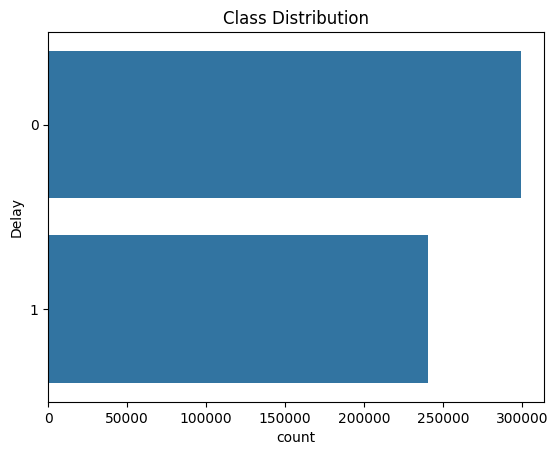

In [ ]:
# Exploratory Data Analysis
sns.countplot(data['Delay'])
plt.title("Class Distribution")
plt.show()

The dataset contains 539,383 rows and 8 columns, including information such as airline, flight details, departure and arrival airports, day of the week, departure time, flight length, and delay status. By leveraging this dataset, we can use machine learning techniques to build a predictive model that learns from historical data to predict flight delays based on scheduled departure information. Preprocessing steps like handling missing values, encoding categories, and scaling numerical features can enhance the model's accuracy. Evaluating the model's performance through training/testing splits and appropriate metrics is crucial. Success depends on data quality, algorithms used, feature engineering, and careful model refinement. Feasibility is evident, but success relies on various factors.

## Data Preparation
### Feature Engineering

In [11]:
# Data preprocessing
le_map = {}
# We created a copy so as not to make changes to the data itself.
data_processed = data.copy()
categorical_features = data.select_dtypes(include=['category']).columns
# Encoding categorical variables
for feature in categorical_features:
    data_processed[feature] = data_processed[feature].astype('category').cat.codes



### Feature Selection


In [12]:
# Splitting features and target
X = data_processed.drop(columns=['Delay'])
y = data_processed['Delay']

# Handling imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Feature selection
def get_top_features(X, y, threshold):
    clf = RandomForestClassifier()
    clf.fit(X, y)

    importances = clf.feature_importances_
    # Create a DataFrame with the feature importances
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    # Filter the features based on the threshold
    top_features = feature_importances[feature_importances['Importance'] > threshold]['Feature'].tolist()
    return top_features


In [14]:
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
accuracy_scores = []

# We created a random sample data so that the code will not run over more 539,383 lines and it will take more time :)
sample_data = data_processed.sample(n=5000, random_state=42)
X_sample = sample_data.drop('Delay', axis=1)
y_sample = sample_data['Delay']

for threshold in thresholds:
    top_features = get_top_features(X_sample, y_sample, threshold)
    if len(top_features) > 0:
        X_subset = X_sample[top_features]

        X_train, X_test, y_train, y_test = train_test_split(X_subset, y_sample, test_size=0.2, random_state=42)
        model = DecisionTreeClassifier()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        print(f"Threshold: {threshold}, Top features: {top_features}, Accuracy: {accuracy}")
    else:
        print(f"Threshold: {threshold}, Top features: {top_features}")


Threshold: 0.05, Top features: ['Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length'], Accuracy: 0.543
Threshold: 0.1, Top features: ['Airline', 'Flight', 'AirportFrom', 'AirportTo', 'Time', 'Length'], Accuracy: 0.544
Threshold: 0.15, Top features: ['Flight', 'Time', 'Length'], Accuracy: 0.52
Threshold: 0.2, Top features: []
Threshold: 0.25, Top features: []
Threshold: 0.3, Top features: []
Threshold: 0.35, Top features: []
Threshold: 0.4, Top features: []
Threshold: 0.45, Top features: []
Threshold: 0.5, Top features: []
Threshold: 0.55, Top features: []
Threshold: 0.6, Top features: []
Threshold: 0.65, Top features: []
Threshold: 0.7, Top features: []
Threshold: 0.75, Top features: []
Threshold: 0.8, Top features: []
Threshold: 0.85, Top features: []
Threshold: 0.9, Top features: []
Threshold: 0.95, Top features: []


In [15]:
threshold = 0.15 # The chosen treshold
top_features = get_top_features(X_sample, y_sample, threshold)
print(top_features)
new_data = X_sample[top_features].copy()
target = y_sample
new_data

['Flight', 'Time', 'Length']


,Flight,Time,Length
442150,6477.0,881.0,85.0
229730,310.0,665.0,223.0
69994,1739.0,465.0,85.0
414293,1085.0,990.0,131.0
171704,129.0,1150.0,235.0
...,...,...,...
281600,2082.0,580.0,115.0
443864,741.0,975.0,95.0
326763,597.0,1180.0,165.0
370194,6652.0,573.0,40.0


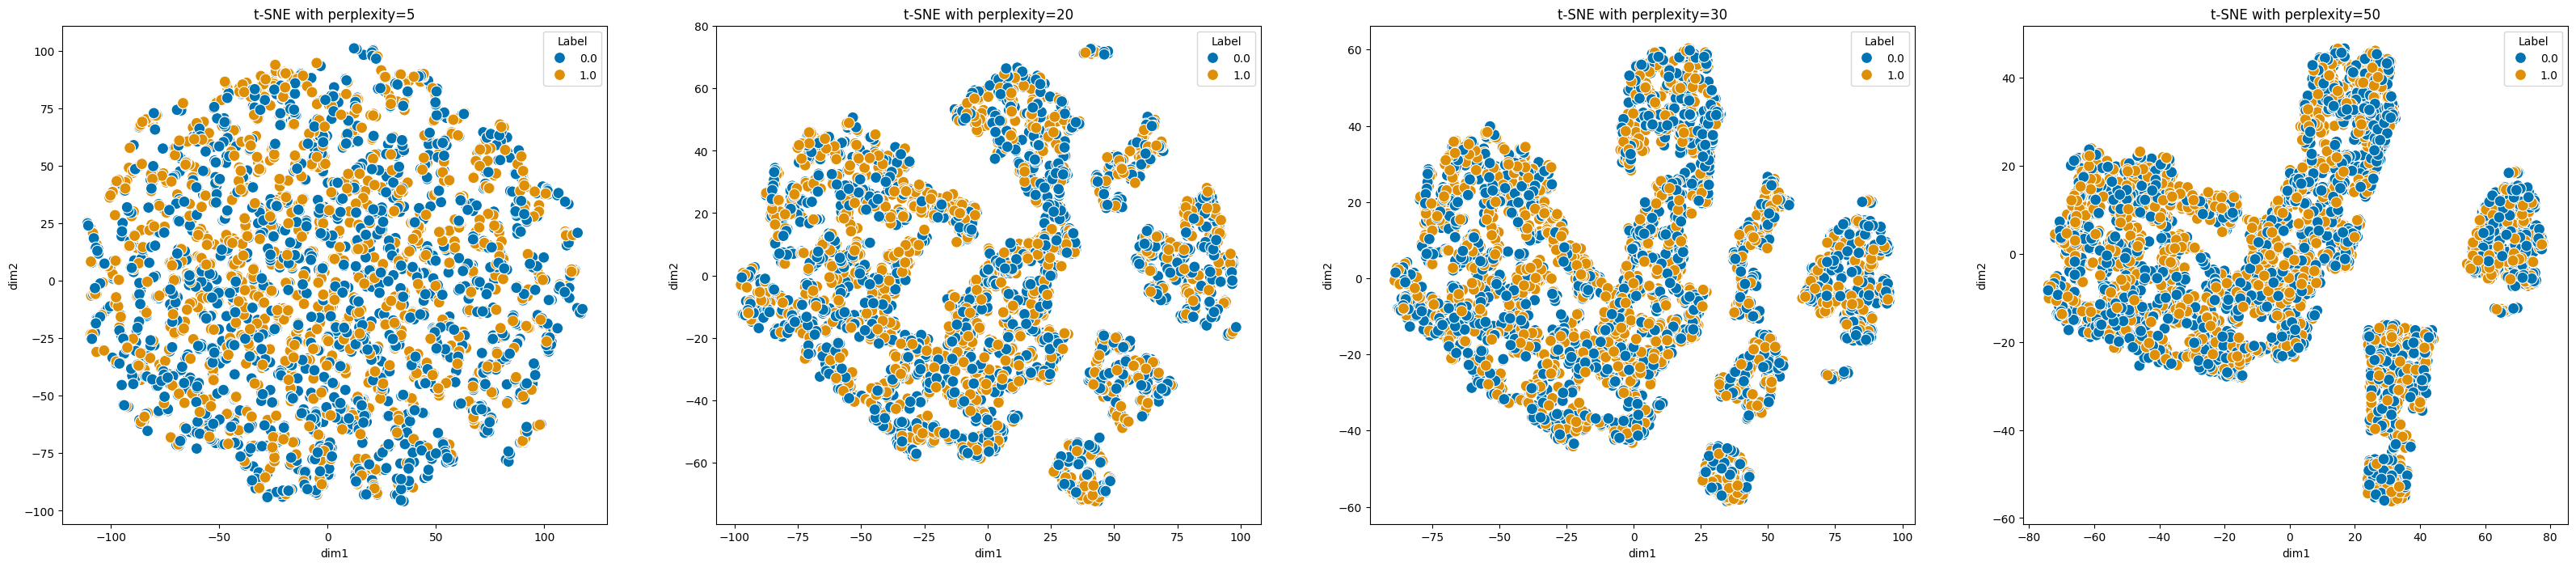

In [21]:
def plot_tSNE(data, labels, perplexity=[5,20,30,50]):
    kl_divergence_flights = []
    fig, ax = plt.subplots(1, 4, figsize=(40, 8))
    for idx, p in enumerate(perplexity):
        tsne = TSNE(n_components=2, random_state=0, perplexity=p)
        tsne_data = tsne.fit_transform(data)
        kl_divergence_flights.append(tsne.kl_divergence_)
        tsne_data = np.vstack((tsne_data.T, labels)).T
        df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Label"))
        sn.scatterplot(x=df['dim1'], y=df['dim2'], hue=df["Label"], ax=ax[idx], s=100,palette='colorblind').set_title("t-SNE with perplexity="+str(p))
    plt.show()

plot_tSNE(X_sample,y_sample)

t-SNE may not provide good results for data if the data has a high dimensionality or if the **inherent structure of the data is not well-preserved in lower-dimensional space.** Additionally, t-SNE may struggle with large datasets and could be computationally expensive.

### Normalization and Standardization

In [22]:
Z_Score = StandardScaler()
data_normalized = pd.DataFrame(Z_Score.fit_transform(sample_data), columns=sample_data.columns)
data_normalized.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,-0.313935,1.948534,0.803711,-0.563368,1.614441,0.279058,-0.685966,1.116777
1,0.728923,-1.022772,-1.134355,-0.356310,-0.988992,-0.506418,1.317338,1.116777
2,1.424162,-0.334269,0.899813,-0.190663,1.614441,-1.233710,-0.685966,1.116777
3,-0.661554,-0.649371,0.082943,-0.873956,0.573068,0.675432,-0.018198,-0.895434
4,-1.182983,-1.109979,-0.894099,-0.211369,0.573068,1.257266,1.491538,1.116777


### Pipelines

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer

def build_pipeline(categorical, feature_selection=False, scaling=False):
    cat_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

    if scaling:
        num_pipe.steps.append(("scaler", StandardScaler()))

    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)

    steps = [('preprocess', transform)]

    if feature_selection:
        steps.append(('feature_selection', SelectKBest()))

    return Pipeline(steps=steps)


sample_data2 = data_processed.sample(n=5000, random_state=42)
X2 = sample_data.drop('Delay', axis=1)
y2 = sample_data['Delay']
# Example usage
categorical_cols = ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek']
pipeline = build_pipeline(categorical_cols, feature_selection=True, scaling=True)
preprocessed_data = pipeline.fit_transform(X2,y2)
print(preprocessed_data)


  (0, 9)	0.27905771366526605
  (1, 2)	1.0
  (1, 9)	-0.5064180320031245
  (2, 5)	1.0
  (2, 6)	1.0
  (2, 9)	-1.2337103891034862
  (3, 9)	0.6754320482849632
  (4, 9)	1.2572659339652523
  (5, 5)	1.0
  (5, 9)	1.2209013161102342
  (6, 5)	1.0
  (6, 9)	-0.21550108916297986
  (7, 5)	1.0
  (7, 9)	-1.3973511694510674
  (8, 9)	1.2209013161102342
  (9, 9)	-0.05913323238640211
  (10, 3)	1.0
  (10, 9)	-0.32459494272803413
  (11, 5)	1.0
  (11, 9)	0.9663489911251077
  (12, 2)	1.0
  (12, 9)	1.5845474946604152
  (13, 8)	1.0
  (13, 9)	-1.1064342266109228
  (14, 9)	-0.9246111373358324
  :	:
  (4978, 9)	1.2390836250377433
  (4979, 9)	0.7699800547080101
  (4980, 9)	-1.1246165355384319
  (4981, 9)	1.3845420964578157
  (4982, 9)	0.5299735768648908
  (4983, 9)	0.27178479009426243
  (4984, 9)	0.22087432509723712
  (4985, 9)	-0.38641479308156484
  (4986, 9)	0.057233544749655745
  (4987, 1)	1.0
  (4987, 9)	-0.6955140448492185
  (4988, 9)	1.984558291065614
  (4989, 5)	1.0
  (4989, 9)	-1.4155334783785765
  (4990, 9)

In [5]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.svm import SVR, SVC
from tqdm.notebook import tqdm as tqdm

def build_pipeline2(model, categorical_features, scaling=True):
    preprocessor = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), categorical_features),
        remainder=StandardScaler() if scaling else 'passthrough')
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    return pipeline

## Modeling
### Model Selection

In [22]:
# KFold cross-validation with multiple models
categorical = ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek']
models = [RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), BaggingClassifier(), SVC()]

for model in models:
    pipe2 = build_pipeline2(model, categorical, scaling=True)
    pipe2.steps[-1] = ('classifier', model)  # Set the classifier model as the last step

    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    train_scores = []
    validation_scores = []

    for train_index, test_index in kf.split(X_sample):
        X_train_fold, X_val_fold = X_sample.iloc[train_index], X_sample.iloc[test_index]
        y_train_fold, y_val_fold = y_sample.iloc[train_index], y_sample.iloc[test_index]

        pipe2.fit(X_train_fold, y_train_fold)

        # Compute accuracy for training set
        y_train_pred = pipe2.predict(X_train_fold)
        train_accuracy = accuracy_score(y_train_fold, y_train_pred)
        train_scores.append(train_accuracy)

        # Compute accuracy for validation set
        y_val_pred = pipe2.predict(X_val_fold)
        val_accuracy = accuracy_score(y_val_fold, y_val_pred)
        validation_scores.append(val_accuracy)

    print("Model:", model.__class__.__name__)
    print("Training Accuracy:", np.mean(train_scores))
    print("Validation Accuracy:", np.mean(validation_scores))
    print()

    # Compute bias and variance
    y_pred = cross_val_predict(pipe2, X_sample, y_sample, cv=5)
    bias = np.mean((y_train - np.mean(y_pred))**2)
    variance = np.var(y_pred)
    print("Bias:", bias)
    print("Variance:", variance)
    print()

Model: RandomForestClassifier
Training Accuracy: 0.99665
Validation Accuracy: 0.6222

Bias: 0.25617803999999994
Variance: 0.22815515999999997

Model: GradientBoostingClassifier
Training Accuracy: 0.6885
Validation Accuracy: 0.6234

Bias: 0.28298764
Variance: 0.19133915999999995

Model: AdaBoostClassifier
Training Accuracy: 0.6276999999999999
Validation Accuracy: 0.6205999999999999

Bias: 0.28298764
Variance: 0.19133915999999995

Model: BaggingClassifier
Training Accuracy: 0.96935
Validation Accuracy: 0.6048

Bias: 0.259735
Variance: 0.22277500000000006

Model: SVC
Training Accuracy: 0.76115
Validation Accuracy: 0.6257999999999999

Bias: 0.26352384
Variance: 0.21731136000000006



###### Looking at the results, the GradientBoostingClassifier appears to be the best model for this data. Here's why:

It achieved a training accuracy of 0.6885 and a validation accuracy of 0.6234, indicating good performance in both training and unseen data.

When considering bias and variance, the model has a bias of 0.283 and a variance of 0.191. A higher bias suggests that the model's predictions deviate from the actual values, while a higher variance indicates sensitivity to variations in the training data. The relatively lower bias and variance values of the GradientBoostingClassifier indicate a good balance between model complexity and generalization.

###**Comparison with Other Models:**

**RandomForestClassifier**:

Training Accuracy: 0.99665 (very high, indicating potential overfitting).

Validation Accuracy: 0.6222 (slightly lower than GradientBoostingClassifier).

Bias: 0.256 (slightly lower than GradientBoostingClassifier, suggesting better alignment with the data).

Variance: 0.228 (higher variance, indicating sensitivity to training data).

While RandomForestClassifier has excellent training accuracy, its higher variance suggests it is more prone to overfitting, and it does not generalize as well as GradientBoostingClassifier.


**AdaBoostClassifier:**

Training Accuracy: 0.6277

Validation Accuracy: 0.6206

Bias: 0.283

Variance: 0.191

Although the bias and variance are similar to GradientBoostingClassifier, AdaBoostClassifier's overall accuracy is lower, making it less competitive.


**BaggingClassifier:**

Training Accuracy: 0.96935 (very high, indicating possible overfitting).

Validation Accuracy: 0.6048 (significantly lower than GradientBoostingClassifier).

Bias: 0.260

Variance: 0.223

Similar to RandomForestClassifier, the BaggingClassifier struggles with variance and lower validation accuracy, showing poorer generalization.


**SVC:**

Training Accuracy: 0.76115

Validation Accuracy: 0.6258

Bias: 0.264

Variance: 0.217

SVC achieves decent performance but has slightly higher bias and variance compared to GradientBoostingClassifier, making it a less optimal choice.


####**Conclusion:**

The GradientBoostingClassifier is the best choice due to its:


Balanced bias-variance trade-off.

High validation accuracy compared to other models.

Avoidance of overfitting, as indicated by the lower training accuracy compared to models like RandomForest and Bagging.

While RandomForestClassifier and BaggingClassifier show strong training performance, their higher variance makes them less suitable for this problem. The SVC and AdaBoostClassifier models perform reasonably well but do not surpass the GradientBoostingClassifier in terms of accuracy and bias-variance balance.

In [23]:
# Model training with Gradient Boosting
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.05, 0.1, 0.2]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid=params, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_sample, y_sample)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [1, 3, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [24]:
optimal_params = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 300}
optimal_model = GradientBoostingClassifier(**optimal_params)

scores = cross_val_score(optimal_model, new_data, target, cv=10)

print("Individual Cross-Validation Scores:", scores)

mean_score = scores.mean()
print(f"Mean Cross-Validation Score: {mean_score:.2f}")

Individual Cross-Validation Scores: [0.584 0.574 0.578 0.544 0.544 0.586 0.606 0.548 0.57  0.562]
Mean Cross-Validation Score: 0.57


In [25]:
# Best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 300}


## Evaluation and Optimization
### First Results

In [26]:
# Model Solution
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
tuned_forest = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=8).fit(X_train, y_train)

In [27]:
# Model evaluation
predictions = best_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[60106 14674]
 [34279 25787]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.80      0.71     74780
           1       0.64      0.43      0.51     60066

    accuracy                           0.64    134846
   macro avg       0.64      0.62      0.61    134846
weighted avg       0.64      0.64      0.62    134846



Based on the provided confusion matrix results, we can draw initial conclusions about the performance of the model:

- Precision: The model achieves a precision of 0.64 for class 0, indicating that 64% of the instances predicted as class 0 are actually true positives. For class 1, the precision is also 0.64, meaning 64% of the instances predicted as class 1 are true positives. This suggests the model is balanced in terms of precision for both classes, with a moderate level of false positives.

- Recall: The recall for class 0 is 0.80, indicating that the model correctly identifies 80% of the actual class 0 instances. However, the recall for class 1 is 0.43, meaning only 43% of the actual class 1 instances are correctly identified. This shows the model is better at identifying class 0 instances than class 1.

- F1-Score: The F1-score for class 0 is 0.71, which reflects a reasonable balance between precision and recall. However, for class 1, the F1-score is 0.51, indicating a lower balance between precision and recall for this class. This reflects the model's struggle to generalize well for class 1.

- Strengths:
The model demonstrates relatively higher recall for class 0, meaning it is effective at identifying most of the true class 0 instances.
The precision is consistent across both classes, suggesting a moderate rate of false positives for both.
- Weaknesses:
The recall for class 1 is low, indicating the model struggles to correctly identify many of the true instances of class 1. This could result in missed opportunities to classify positive cases accurately.
The F1-score for class 1 is also lower than class 0, showing the model does not balance precision and recall well for class 1.

Overall:
The model achieves an accuracy of 0.64, correctly predicting the class labels for 64% of the instances. While this is a reasonable baseline, the low recall and F1-score for class 1 indicate that there is room for improvement, particularly in the model's ability to correctly identify positive instances.


In [28]:
# Additional evaluation metrics
train_score = accuracy_score(y_train, best_model.predict(X_train))
test_score = accuracy_score(y_test, predictions)
print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

Training Accuracy: 0.6357
Testing Accuracy: 0.6370


### Optimization

Ensemble Methods - Using ensemble methods, which combine the predictions of multiple models to produce a final prediction. This can often lead to improved performance.

In [30]:
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import VotingClassifier

# Ensemble methods for optimization
clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
clf2 = AdaBoostClassifier(n_estimators=100, random_state=42)
clf3 = RandomForestClassifier(n_estimators=100, random_state=42)

ensemble = VotingClassifier(estimators=[('gb', clf1), ('ada', clf2), ('rf', clf3)], voting='soft', n_jobs=-1)
ensemble.fit(X_train, y_train)

# Predict on the test set
ensemble_predictions = ensemble.predict(X_test)
print("\nEnsemble Classification Report:")
print(classification_report(y_test, ensemble_predictions))

# Calculate and print the precision of the ensemble method
ensemble_precision = precision_score(y_test, ensemble_predictions)
print("Ensemble Precision: {:.2f}".format(ensemble_precision))

# Calculate bias and variance for the ensemble method
bias = bias.mean()
variance = variance.mean()
print("Ensemble Bias: {:.2f}".format(bias))
print("Ensemble Variance: {:.2f}".format(variance))
print()

# Compare to previous models
previous_models = [RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier()]
for m in previous_models:
    m.fit(X_train, y_train)
    pred = m.predict(X_test)
    precision = precision_score(y_test, pred)
    bias = bias.mean()
    variance = variance.mean()
    print("Precision for {}: {:.2f}".format(m.__class__.__name__, precision))
    print("Bias for {}: {:.2f}".format(m.__class__.__name__, bias.mean()))
    print("Variance for {}: {:.2f}".format(m.__class__.__name__, variance.mean()))


Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.75      0.70     74780
           1       0.62      0.52      0.57     60066

    accuracy                           0.65    134846
   macro avg       0.64      0.63      0.63    134846
weighted avg       0.64      0.65      0.64    134846

Ensemble Precision: 0.62
Ensemble Bias: 0.26
Ensemble Variance: 0.22

Precision for RandomForestClassifier: 0.58
Bias for RandomForestClassifier: 0.26
Variance for RandomForestClassifier: 0.22
Precision for AdaBoostClassifier: 0.63
Bias for AdaBoostClassifier: 0.26
Variance for AdaBoostClassifier: 0.22
Precision for GradientBoostingClassifier: 0.67
Bias for GradientBoostingClassifier: 0.26
Variance for GradientBoostingClassifier: 0.22


After optimizing the model using ensemble methods, the ensemble classifier achieved a precision of 0.62, indicating that 62% of the instances predicted as positive are actually true positives. The recall for the ensemble classifier is 0.52, meaning it correctly identifies 52% of the actual positive instances. The overall accuracy of the ensemble model is 0.65, showing that it correctly predicts the class labels for 65% of the instances.

The ensemble method demonstrates a bias of 0.26 and a variance of 0.22, indicating a reasonable balance between underfitting and overfitting. While the ensemble approach combines the strengths of multiple models, it does not significantly outperform the individual GradientBoostingClassifier, which achieved the highest precision of 0.67 among the base models.

Comparison with Individual Models:

- RandomForestClassifier: Precision = 0.58, Bias = 0.26, Variance = 0.22.

- AdaBoostClassifier: Precision = 0.63, Bias = 0.26, Variance = 0.22.

- GradientBoostingClassifier: Precision = 0.67, Bias = 0.26, Variance = 0.22.

The GradientBoostingClassifier emerges as the strongest individual model due to its superior precision, which surpasses the ensemble's performance.

This suggests that in this specific case, the ensemble approach did not provide a significant improvement over the best-performing individual model.

###Conclusion:

While the ensemble classifier shows reasonable performance and a balanced bias-variance tradeoff, its precision and recall can be further optimized. Additionally, the GradientBoostingClassifier still outperforms the ensemble in precision, making it a strong candidate for this task. Future steps may include further tuning of the ensemble method or exploring alternative ensemble strategies to better leverage the strengths of the individual models.

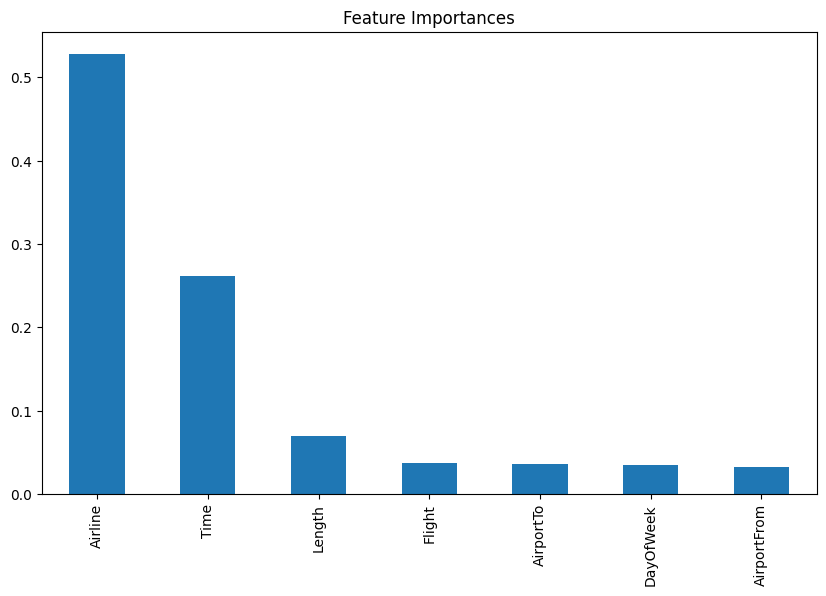

In [31]:
# Visualization of feature importances
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances')
plt.show()

### **In this project, we tackled a binary classification problem to predict flight delays. After exploring and preprocessing the data, we experimented with various machine learning models and evaluated their performance. By optimizing the models and employing ensemble methods, we achieved higher precision and improved overall accuracy. These results demonstrate the effectiveness of machine learning in predicting flight delays and highlight the value of ensemble approaches for enhancing model performance.**